# Rayleigh-Taylor Instability


We will simulate the incompressible Rayleigh-Taylor instability.  We non-dimensionalize the problem by taking the box height to be one.  Then the Reynolds number is given by

$$ \mathrm{Re} = \frac{U H}{\nu} = \frac{\sqrt{g}}{\nu}. $$ with $U = \sqrt{gH}$.

We use no slip boundary conditions, and a box with aspect ratio $L/H=2$.  The fluid is initialy at rest, and only a single mode is initially excited.  We will also track a passive scalar which will help us visualize the instability.

First, we import the necessary modules.

In [14]:
%matplotlib inline

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time
from IPython import display

from dedalus import public as de
from dedalus.extras import flow_tools

import logging   
logger = logging.getLogger(__name__)

To perform an initial value problem (IVP) in Dedalus, you need three things:

1. A domain to solve the problem on
2. Equations to solve
3. A timestepping scheme

## Problem Domain

First, we will specify the domain.  Domains are built by taking the direct product of bases.  Here we are running a 2D simulation, so we will define $x$ and $y$ bases.  From these, we build the domain.

In [16]:
#Aspect ratio 2
Lx, Ly = (2., 1.)
nx, ny = (192, 96)

# Create bases and domain
x_basis = de.Fourier('x', nx, interval=(0, Lx), dealias=3/2)
y_basis = de.Chebyshev('y',ny, interval=(-Ly/2, Ly/2), dealias=3/2)
domain = de.Domain([x_basis, y_basis], grid_dtype=np.float64)

The last basis ($y$ direction) is represented in Chebyshev polynomials.  This will allow us to apply interesting boundary conditions in the $y$ direction.  We call the other directions (in this case just $x$) the "horizontal" directions.  The horizontal directions must be "easy" in the sense that taking derivatives cannot couple different horizontal modes.  Right now, we have Fourier and Sin/Cos series implemented for the horizontal directions, and are working on implementing spherical harmonics.

## Equations

Next we will define the equations that will be solved on this domain.  The equations are

$$ \partial_t u + \boldsymbol{u}\boldsymbol{\cdot}\boldsymbol{\nabla} u + \partial_x p = \frac{1}{{\rm Re}} \nabla^2 u $$
$$ \partial_t v + \boldsymbol{u}\boldsymbol{\cdot}\boldsymbol{\nabla} v + \partial_y p +\beta S = \frac{1}{{\rm Re}} \nabla^2 v $$
$$ \boldsymbol{\nabla}\boldsymbol{\cdot}\boldsymbol{u} = 0 $$
$$ \partial_t s + \boldsymbol{u}\boldsymbol{\cdot}\boldsymbol{\nabla} s = \frac{1}{{\rm Re}{\rm Sc}} \nabla^2 s $$

The equations are written such that the left-hand side (LHS) is treated implicitly, and the right-hand side (RHS) is treated explicitly.  The LHS is limited to only linear terms, though linear terms can also be placed on the RHS.  Since $y$ is our special direction in this example, we also restrict the LHS to be at most first order in derivatives with respect to $y$.
Note: The Navier-Stokes equations have been written such that $p \rightarrow p+y$ because the gravity term in the y momentum equation of the N-S equations can be accounted for in the pressure term.

We also set the parameters, the Reynolds and Schmidt numbers.

In [17]:
Reynolds = 200
Schmidt = 10
Atwood = 0.4

problem = de.IVP(domain, variables=['p','u','v','uy','vy','S','Sy'])
problem.parameters['Re'] = Reynolds
problem.parameters['Sc'] = Schmidt
problem.parameters['beta'] = 2*Atwood/(1-Atwood)

problem.add_equation("dt(u) + dx(p) - 1/Re*(dx(dx(u)) + dy(uy)) = - u*dx(u) - v*uy")
problem.add_equation("dt(v) + dy(p) - 1/Re*(dx(dx(v)) + dy(vy)) + beta * S = - u*dx(v) - v*vy")
problem.add_equation("dx(u) + vy = 0")
problem.add_equation("dt(S) - 1/(Re*Sc)*(dx(dx(S)) + dy(Sy)) = - u*dx(S) - v*Sy")
problem.add_equation("uy - dy(u) = 0")
problem.add_equation("vy - dy(v) = 0")
problem.add_equation("Sy - dy(S) = 0")

Because we are using this first-order formalism, we define auxiliary variables `uy`, `vy`, and `Sy` to be the $y$-derivative of `u`, `v`, and `S` respectively.

Next, we set our boundary conditions.  "Left" boundary conditions are applied at $y=-Ly/2$ and "right" boundary conditions are applied at $y=+Ly/2$.

In [18]:
problem.add_bc("left(uy) = 0")
problem.add_bc("right(uy) = 0")
problem.add_bc("left(v) = 0")
problem.add_bc("right(v) = 0", condition="(nx != 0)")
problem.add_bc("left(p) = 0", condition="(nx == 0)")
problem.add_bc("left(Sy) = 0")
problem.add_bc("right(Sy) = 0")

Note that we have a special boundary condition for the $k_x=0$ mode (singled out by `condition="(nx==0)"`).  This is because the continuity equation implies $\partial_y v=0$ if $k_x=0$; thus, $v=0$ on the top and bottom are redundant boundary conditions.  We replace one of these with a gauge choice for the pressure.


## Timestepping

We have implemented a variety of multi-step and Runge-Kutta implicit-explicit timesteppers in Dedalus.  The available options can be seen in the [timesteppers.py module](https://github.com/DedalusProject/dedalus/blob/master/dedalus/core/timesteppers.py).  For this problem, we will use a third-order, four-stage Runge-Kutta integrator.  Changing the timestepping algorithm is as easy as changing one line of code.

In [19]:
ts = de.timesteppers.RK443

## Initial Value Problem

We now have the three ingredients necessary to set up our IVP:

In [20]:
solver =  problem.build_solver(ts)

2020-12-01 00:24:19,504 pencil 0/1 INFO :: Building pencil matrix 1/96 (~1%) Elapsed: 0s, Remaining: 3s, Rate: 3.0e+01/s
2020-12-01 00:24:19,721 pencil 0/1 INFO :: Building pencil matrix 10/96 (~10%) Elapsed: 0s, Remaining: 2s, Rate: 4.0e+01/s
2020-12-01 00:24:19,996 pencil 0/1 INFO :: Building pencil matrix 20/96 (~21%) Elapsed: 1s, Remaining: 2s, Rate: 3.8e+01/s
2020-12-01 00:24:20,231 pencil 0/1 INFO :: Building pencil matrix 30/96 (~31%) Elapsed: 1s, Remaining: 2s, Rate: 3.9e+01/s
2020-12-01 00:24:20,460 pencil 0/1 INFO :: Building pencil matrix 40/96 (~42%) Elapsed: 1s, Remaining: 1s, Rate: 4.0e+01/s
2020-12-01 00:24:20,726 pencil 0/1 INFO :: Building pencil matrix 50/96 (~52%) Elapsed: 1s, Remaining: 1s, Rate: 4.0e+01/s
2020-12-01 00:24:20,964 pencil 0/1 INFO :: Building pencil matrix 60/96 (~62%) Elapsed: 1s, Remaining: 1s, Rate: 4.0e+01/s
2020-12-01 00:24:21,184 pencil 0/1 INFO :: Building pencil matrix 70/96 (~73%) Elapsed: 2s, Remaining: 1s, Rate: 4.1e+01/s
2020-12-01 00:24:2

Now we set our initial conditions.  We set the horizontal velocity to zero and scalar field to a tanh profile, and using a single-mode initial perturbation in $v$.

In [21]:
x = domain.grid(0)
y = domain.grid(1)
u = solver.state['u']
uy = solver.state['uy']
v = solver.state['v']
vy = solver.state['vy']
S = solver.state['S']
Sy = solver.state['Sy']

a = 0.005
amp = -0.002
u['g'] = 0
v['g'] = 0
S['g'] = 0.5*(1+np.tanh((y-amp*np.sin(8.0*np.pi*x/Lx))/a))
u.differentiate('y',out=uy)
v.differentiate('y',out=vy)
S.differentiate('y',out=Sy)

<Field 140586159263808>

Now we set integration parameters and the CFL.

In [22]:
solver.stop_sim_time = 4.01
solver.stop_wall_time = np.inf
solver.stop_iteration = np.inf

#initial_dt = 0.2*Lx/nx
#cfl = flow_tools.CFL(solver,initial_dt,safety=0.8)
#cfl.add_velocities(('u','v'))

## Analysis

We have a sophisticated analysis framework in which the user specifies analysis tasks as strings.  Users can output full data cubes, slices, volume averages, and more.  Here we will only output a few 2D slices, and a 1D profile of the horizontally averaged concentration field.  Data is output in the hdf5 file format.

In [23]:
analysis = solver.evaluator.add_file_handler('analysis_tasks', sim_dt=0.1, max_writes=50)
analysis.add_task('S')
analysis.add_task('u')
solver.evaluator.vars['Lx'] = Lx
analysis.add_task("integ(S,'x')/Lx", name='S profile')

## Main Loop

We now have everything set up for our simulation.  In Dedalus, the user writes their own main loop.

2020-12-01 00:28:07,224 __main__ 0/1 INFO :: Run time: 225.092727
2020-12-01 00:28:07,227 __main__ 0/1 INFO :: Iterations: 1925


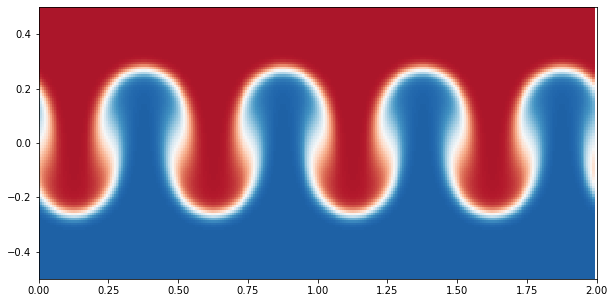

In [24]:
# Make plot of scalar field
x = domain.grid(0,scales=domain.dealias)
y = domain.grid(1,scales=domain.dealias)
xm, ym = np.meshgrid(x,y)
fig, axis = plt.subplots(figsize=(10,5))
p = axis.pcolormesh(xm, ym, S['g'].T, cmap='RdBu_r');
axis.set_xlim([0,2.])
axis.set_ylim([-0.5,0.5])

logger.info('Starting loop')
start_time = time.time()
while solver.ok:
    #dt = cfl.compute_dt()
    dt = 0.2*Lx/nx
    #print(dt)
    #time.sleep(5)
    solver.step(dt)
    if solver.iteration % 10 == 0:
        # Update plot of scalar field
        p.set_array(np.ravel(S['g'][:-1,:-1].T))
        display.clear_output()
        display.display(plt.gcf())
        logger.info('Iteration: %i, Time: %e, dt: %e' %(solver.iteration, solver.sim_time, dt))

end_time = time.time()

p.set_array(np.ravel(S['g'][:-1,:-1].T))
display.clear_output()
# Print statistics
logger.info('Run time: %f' %(end_time-start_time))
logger.info('Iterations: %i' %solver.iteration)

## Analysis

As an example of doing some analysis, we will load in the horizontally averaged profiles of the scalar field $s$ and plot them.

In [25]:
# Read in the data
f = h5py.File('analysis_tasks/analysis_tasks_s1/analysis_tasks_s1_p0.h5','r')
y = f['/scales/y/1.0'][:]
t = f['scales']['sim_time'][:]
S_ave = f['tasks']['S profile'][:]
f.close()

S_ave = S_ave[:,0,:] # remove length-one x dimension

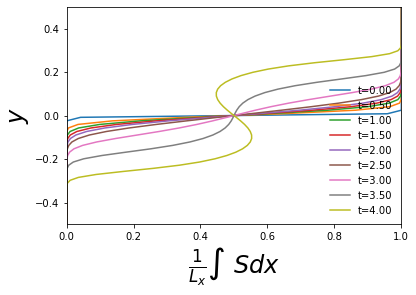

In [26]:
#N = len(S_ave[:,1])
for i in range(0,41,5):
  plt.plot(S_ave[i,:],y,label='t=%4.2f' %t[i])

plt.ylim([-0.5,0.5])
plt.xlim([0,1])
plt.xlabel(r'$\frac{1}{L_x}\int \ S dx$',fontsize=24)
plt.ylabel(r'$y$',fontsize=24)
plt.legend(loc='lower right').draw_frame(False)